<a href="https://colab.research.google.com/github/R4j4n/Realization-of-arcface-loss-function-on-mnist-dataset/blob/master/ARCFACE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as t
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import os

In [ ]:

class ArcLoss(nn.Module):
    def __init__(self,class_num,feature_num,s=10,m=0.1):
        super().__init__()
        self.class_num=class_num
        self.feature_num=feature_num
        self.s = s
        self.m = t.tensor(m)
        self.w=nn.Parameter(t.rand(feature_num,class_num))
    #2*10
    def forward(self,feature):
        feature = F.normalize(feature,dim=1) #128*2
        w = F.normalize(self.w,dim=0) #2*10
        cos_theat = t.matmul(feature,w)/10
        sin_theat = t.sqrt(1.0-t.pow(cos_theat,2))
        cos_theat_m = cos_theat*t.cos(self.m) - sin_theat*t.sin(self.m)
        cos_theat_ = t.exp(cos_theat * self.s)
        sum_cos_theat =t.sum(t.exp(cos_theat*self.s),dim=1,keepdim=True)-cos_theat_
        top = t.exp(cos_theat_m*self.s)
        divide = (top/(top+sum_cos_theat))

        return divide   

In [ ]:

Batch_Size = 128

transforms =tv.transforms.Compose([tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.1307,), (0.3081,))])

train_data = tv.datasets.MNIST( root="/content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data",
                                train=True,
                                download=True,
                                transform = transforms)

test_data = tv.datasets.MNIST( root="/content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data",
                                train=False,
                                download=True,
                                transform = transforms)

train_loader = data.DataLoader(train_data,
                batch_size=Batch_Size, shuffle=True,
                drop_last=True,num_workers=2)

test_load = data.DataLoader(dataset = test_data, 
                            batch_size = Batch_Size,
                            shuffle = False)




Extracting /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw




Extracting /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw




Extracting /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/MNIST-Data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,16,3, 2, 1),
            nn.ReLU())
        self.linear_layer = nn.Linear(16*4*4,3)
        self.output_layer = nn.Linear(3,10,bias=False)
    def forward(self, xs):
        feat = self.hidden_layer(xs)
        # print(feature.shape)
        fc = feat.reshape(-1,16*4*4)
        # print(fc.data.size())
        feature = self.linear_layer(fc)
        output = self.output_layer(feature)
        return feature, F.log_softmax(output,dim=1)

In [ ]:
def decet(feature,targets,epoch,save_path):
    color = ["red", "black", "yellow", "green", "pink",
    "gray", "lightgreen", "orange", "blue", "teal"]
    cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    plt.ion()
    plt.clf()
    for j in cls:
        mask = [targets == j]
        feature_ = feature[mask].numpy()
        x = feature_[:, 1]
        y = feature_[:, 0]
        label = cls
        plt.plot(x, y, ".", color=color[j])
        plt.legend(label, loc="upper right") 
        plt.title("epoch={}".format(str(epoch+1)))
    plt.savefig('{}/{}.jpg'.format(save_path,epoch+1))
    plt.draw()
    plt.pause(0.01)

In [ ]:
net = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()    
      
arcloss = ArcLoss(10, 3).cuda()
nllloss = nn.NLLLoss(reduction="sum").cuda()
optmizer = t.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
optmizerarc = t.optim.Adam(arcloss.parameters())

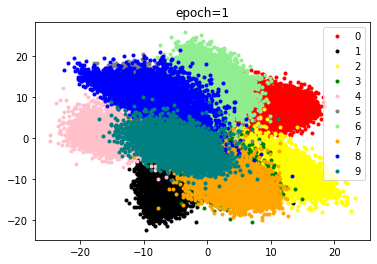

Epoch 1/50, Training Loss: 0.744, Training Accuracy: 0.953


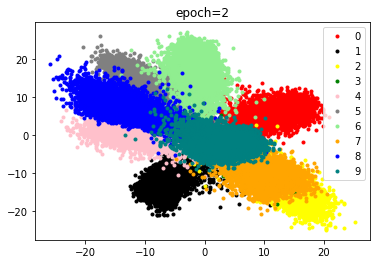

Epoch 2/50, Training Loss: 0.664, Training Accuracy: 0.969


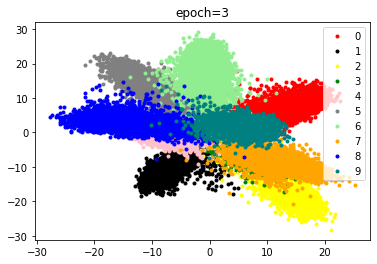

Epoch 3/50, Training Loss: 0.654, Training Accuracy: 0.977


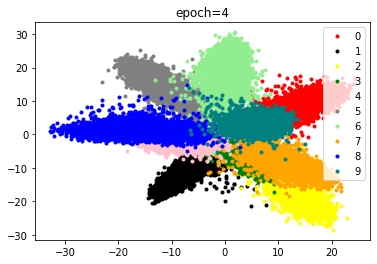

Epoch 4/50, Training Loss: 0.648, Training Accuracy: 0.984


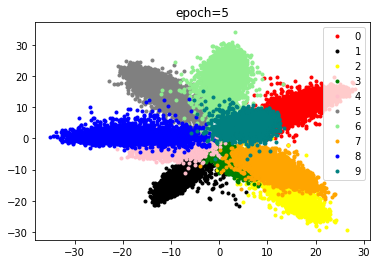

Epoch 5/50, Training Loss: 0.633, Training Accuracy: 1.000


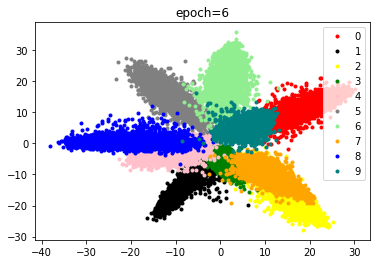

Epoch 6/50, Training Loss: 0.632, Training Accuracy: 1.000


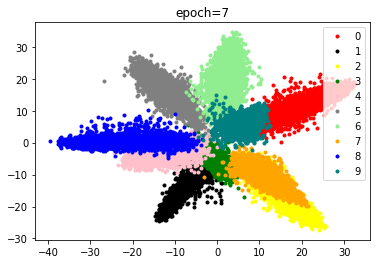

Epoch 7/50, Training Loss: 0.633, Training Accuracy: 1.000


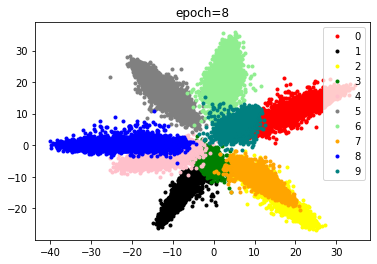

Epoch 8/50, Training Loss: 0.633, Training Accuracy: 1.000


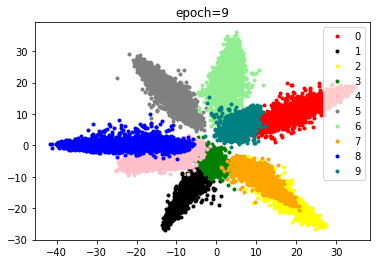

Epoch 9/50, Training Loss: 0.632, Training Accuracy: 1.000


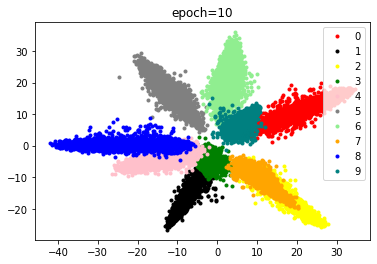

Epoch 10/50, Training Loss: 0.631, Training Accuracy: 1.000


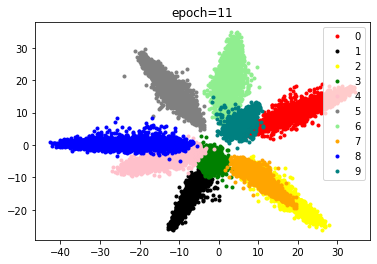

Epoch 11/50, Training Loss: 0.631, Training Accuracy: 1.000


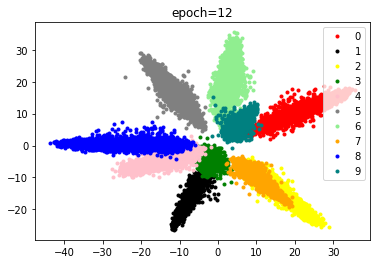

Epoch 12/50, Training Loss: 0.631, Training Accuracy: 1.000


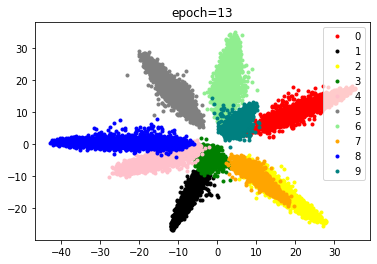

Epoch 13/50, Training Loss: 0.631, Training Accuracy: 1.000


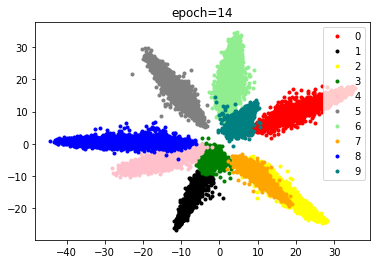

Epoch 14/50, Training Loss: 0.631, Training Accuracy: 1.000


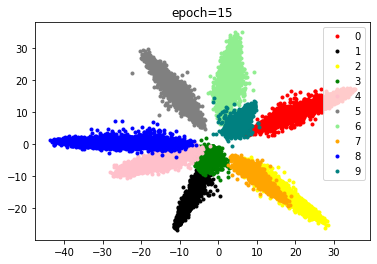

Epoch 15/50, Training Loss: 0.631, Training Accuracy: 1.000


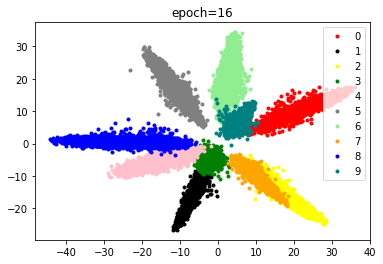

Epoch 16/50, Training Loss: 0.631, Training Accuracy: 1.000


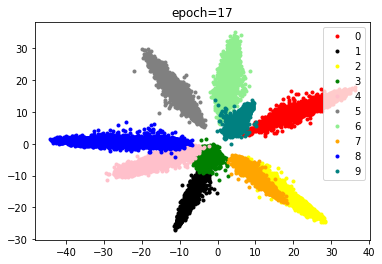

Epoch 17/50, Training Loss: 0.631, Training Accuracy: 1.000


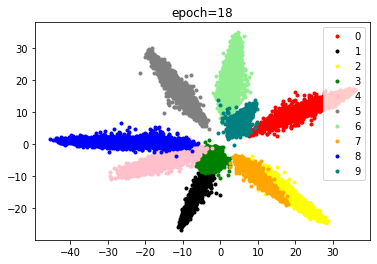

Epoch 18/50, Training Loss: 0.632, Training Accuracy: 1.000


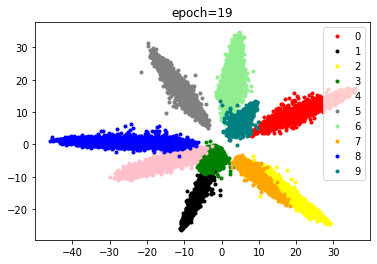

Epoch 19/50, Training Loss: 0.631, Training Accuracy: 1.000


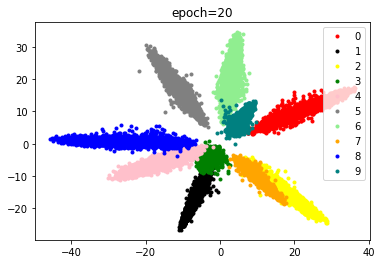

Epoch 20/50, Training Loss: 0.630, Training Accuracy: 1.000


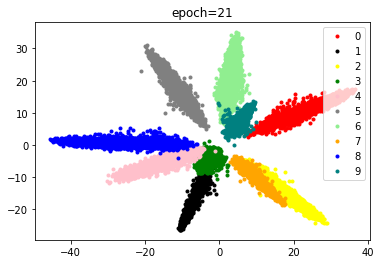

Epoch 21/50, Training Loss: 0.632, Training Accuracy: 1.000


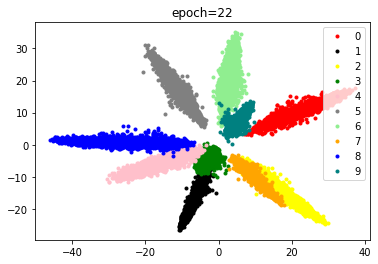

Epoch 22/50, Training Loss: 0.631, Training Accuracy: 1.000


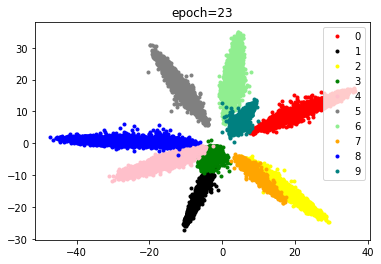

Epoch 23/50, Training Loss: 0.631, Training Accuracy: 1.000


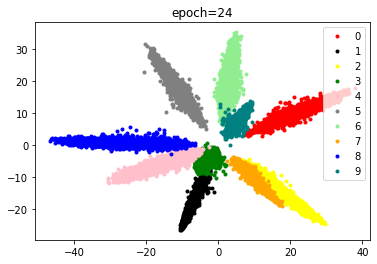

Epoch 24/50, Training Loss: 0.631, Training Accuracy: 1.000


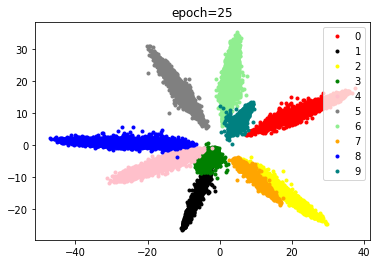

Epoch 25/50, Training Loss: 0.631, Training Accuracy: 1.000


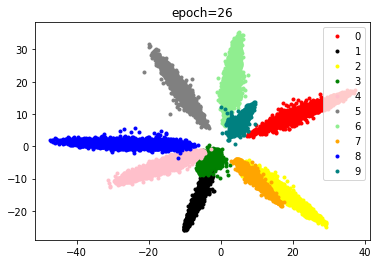

Epoch 26/50, Training Loss: 0.631, Training Accuracy: 1.000


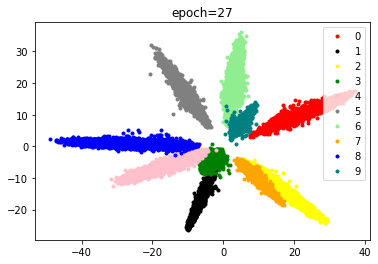

Epoch 27/50, Training Loss: 0.630, Training Accuracy: 1.000


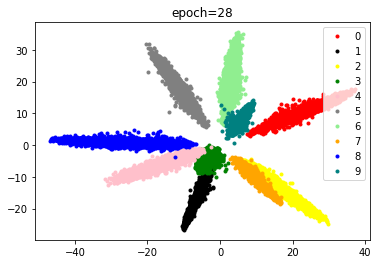

Epoch 28/50, Training Loss: 0.631, Training Accuracy: 1.000


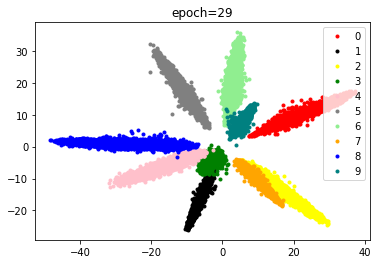

Epoch 29/50, Training Loss: 0.630, Training Accuracy: 1.000


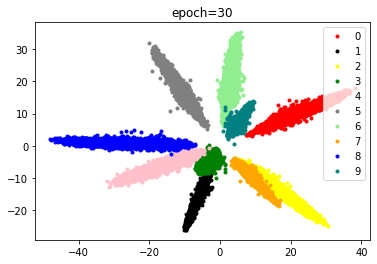

Epoch 30/50, Training Loss: 0.631, Training Accuracy: 1.000


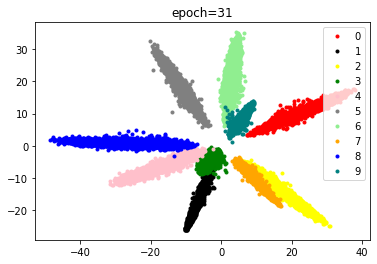

Epoch 31/50, Training Loss: 0.631, Training Accuracy: 1.000


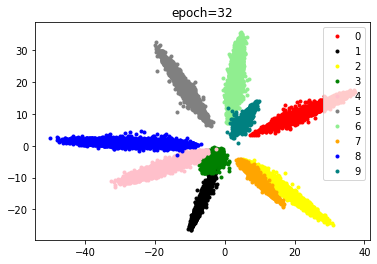

Epoch 32/50, Training Loss: 0.631, Training Accuracy: 1.000


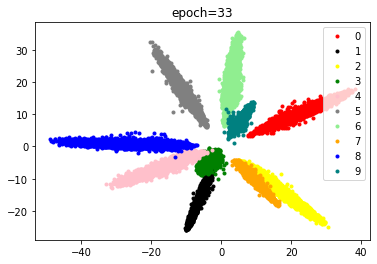

Epoch 33/50, Training Loss: 0.631, Training Accuracy: 1.000


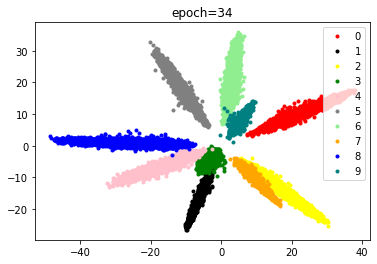

Epoch 34/50, Training Loss: 0.631, Training Accuracy: 1.000


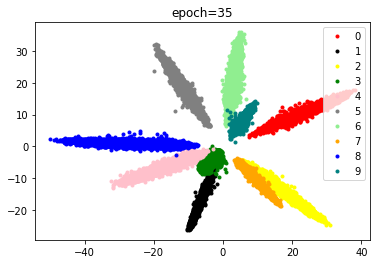

Epoch 35/50, Training Loss: 0.631, Training Accuracy: 1.000


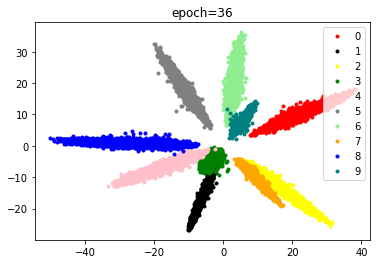

Epoch 36/50, Training Loss: 0.631, Training Accuracy: 1.000


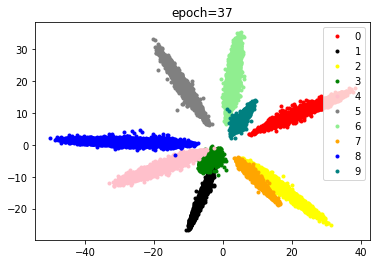

Epoch 37/50, Training Loss: 0.630, Training Accuracy: 1.000


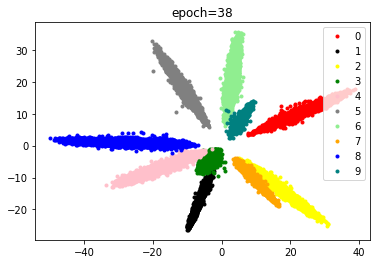

Epoch 38/50, Training Loss: 0.630, Training Accuracy: 1.000


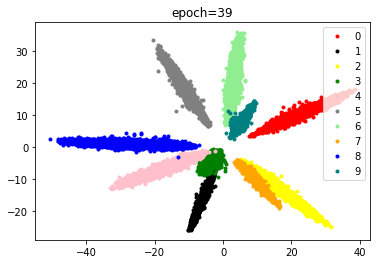

Epoch 39/50, Training Loss: 0.630, Training Accuracy: 1.000


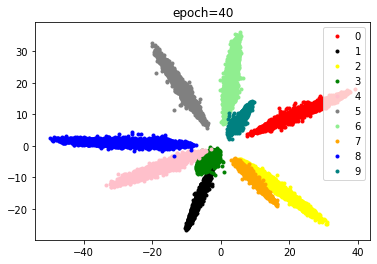

Epoch 40/50, Training Loss: 0.631, Training Accuracy: 1.000


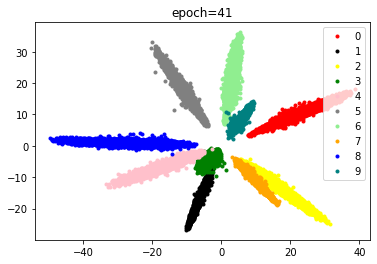

Epoch 41/50, Training Loss: 0.630, Training Accuracy: 1.000


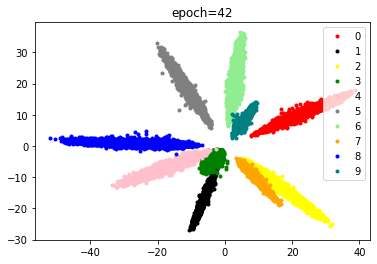

Epoch 42/50, Training Loss: 0.631, Training Accuracy: 1.000


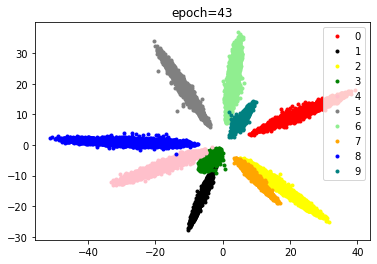

Epoch 43/50, Training Loss: 0.630, Training Accuracy: 1.000


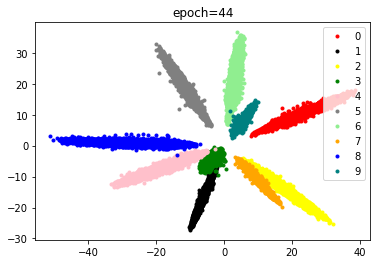

Epoch 44/50, Training Loss: 0.630, Training Accuracy: 1.000


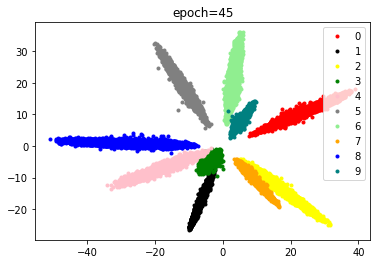

Epoch 45/50, Training Loss: 0.630, Training Accuracy: 1.000


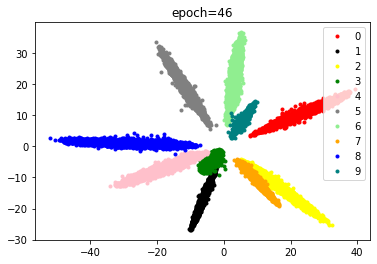

Epoch 46/50, Training Loss: 0.631, Training Accuracy: 1.000


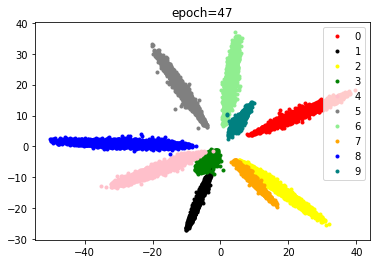

Epoch 47/50, Training Loss: 0.631, Training Accuracy: 1.000


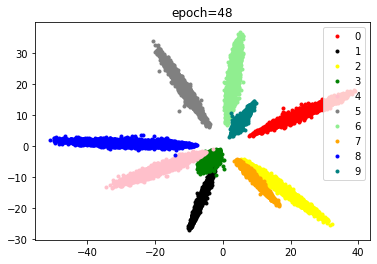

Epoch 48/50, Training Loss: 0.631, Training Accuracy: 1.000


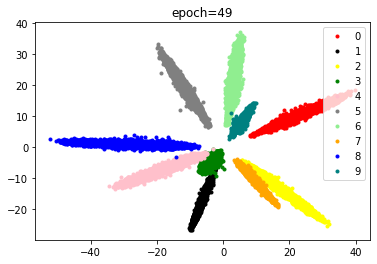

Epoch 49/50, Training Loss: 0.630, Training Accuracy: 1.000


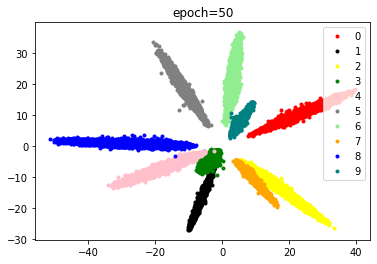

Epoch 50/50, Training Loss: 0.631, Training Accuracy: 1.000


In [ ]:

save_pic_path = r"/content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/Images/"
if __name__ == '__main__':
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    num_epochs = 50
    # net = net.to(device)
    for epoch in range(num_epochs):
        correct = 0
        iterations = 0
        iter_loss = 0.0
        feat = []
        target = []
        net.train()  
        feat = []
        target = []
        for i, (x, y) in enumerate(train_loader):

            if CUDA:
                x = x.cuda()
                y = y.cuda()
            xs, ys = net(x) 
            
            ############ ACCURACY CAL. ###########
            value = t.argmax(ys, dim=1)
            acc = t.sum((value == y).float()) / len(y)
            
            ################ LOSS CAL. ################
            arc_loss = t.log(arcloss(xs))
            nll_loss = nllloss(ys, y)
            arcface_loss = nllloss(arc_loss, y)
            loss = nll_loss + arcface_loss
            iter_loss = loss.item()
            ###########################################
            
            ############ BACK PROP #################
            optmizer.zero_grad()
            optmizerarc.zero_grad()
            loss.backward()
            optmizer.step()
            optmizerarc.step()
            ########################################
            feat.append(xs) 
            target.append(y)
            iterations += 1 

        
        features = t.cat(feat, 0)
        targets = t.cat(target, 0)
        decet(features.data.cpu(), targets.data.cpu(),epoch,save_pic_path)
        train_loss.append(iter_loss/ iterations)
        train_accuracy.append(acc)
        print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1]))    
    
    
    
    
    PATH = "/content/drive/MyDrive/Colab Notebooks/ARCFACE-3D/model.pth"
    torch.save(net.state_dict(),PATH)

In [ ]:
net.load_state_dict(torch.load(PATH))
net.eval()

TrainNet(
  (hidden_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
  )
  (linear_layer): Linear(in_features=256, out_features=3, bias=True)
  (output_layer): Linear(in_features=3, out_features=10, bias=False

In [ ]:
from tqdm.notebook import tqdm

emb = []
y = []

with torch.no_grad():
    for images,labels in tqdm(test_load):
        
        images = images.cuda()
        embeddings = net(images)[0]
        
        emb += [embeddings.detach().cpu()]
        y += [labels]
        
    embs = torch.cat(emb).cpu().numpy()
    y = torch.cat(y).cpu().numpy()

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

tsne_df = pd.DataFrame(
    np.column_stack((embs, y)),
    columns = ["x","y","z","targets"]

)

fig = px.scatter_3d(tsne_df, x='x', y='y', z='z',
              color='targets')
fig.show()